# 1-4,时间序列数据建模流程范例

国内的新冠肺炎疫情从发现至今已经持续3个多月了，这场起源于吃野味的灾难给大家的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

那么国内的新冠肺炎疫情何时结束呢？什么时候我们才可以重获自由呢？

本篇文章将利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。

### 一，准备数据

本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》

![](./data/1-4-新增人数.png)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, losses, metrics, callbacks

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

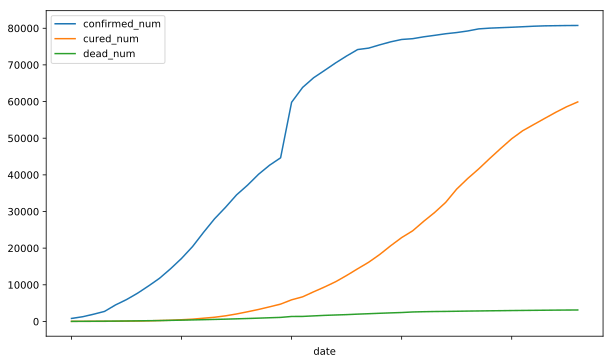

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

df = pd.read_csv("./data/covid-19.csv", sep='\t')
df.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(10, 6))
plt.xticks(rotation=60)

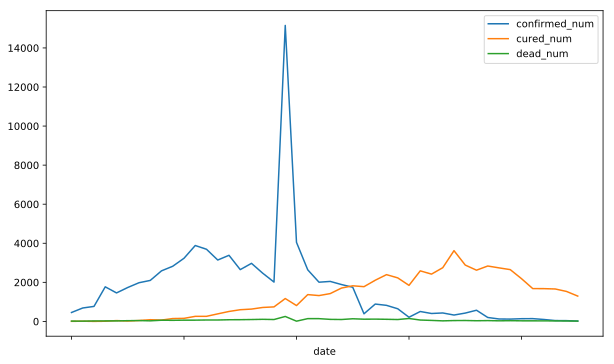

In [10]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x="date", y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [12]:
# 用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8
def batch_dataset(dateset):
    dateset_batched = dateset.batch(WINDOW_SIZE, drop_remainder=True)
    return dateset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype=tf.float32)) \
                .window(WINDOW_SIZE, shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
                tf.constant(dfdiff.values[WINDOW_SIZE:], dtype=tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data, ds_label)).batch(38).cache()

### 二，定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建任意结构模型。

In [13]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [14]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape=(None, 3), dtype=tf.float32)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x_input)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x)
x = layers.LSTM(3, input_shape=(None, 3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input, x)
model = models.Model(inputs=[x_input], outputs=[x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

### 三，训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [22]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self, y_true, y_pred):
        err_precent = (y_true - y_pred)**2 /(tf.maximum(y_true**2, 1e-7))
        mean_err_precent = tf.reduce_mean(err_precent)
        return mean_err_precent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config


In [24]:
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=MSPE(name="MSPE"))

log_dir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
# 如果 loss 在 100 个 epoch 没有提升，学习率减半
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=100)
# 当 loss 在 200 个 epoch 后没有提升，则终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=200)
callbacks_list = [tb_callback, lr_callback, stop_callback]

history = model.fit(ds_train, epochs=500, callbacks=callbacks_list)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 3.3525
Epoch 2/500
1/1 [==============================] - 0s 34ms/step - loss: 3.0914
Epoch 3/500
1/1 [==============================] - 0s 30ms/step - loss: 2.8214
Epoch 4/500
1/1 [==============================] - 0s 30ms/step - loss: 2.5403
Epoch 5/500
1/1 [==============================] - 0s 31ms/step - loss: 2.2497
Epoch 6/500
1/1 [==============================] - 0s 30ms/step - loss: 1.9552
Epoch 7/500
1/1 [==============================] - 0s 31ms/step - loss: 1.6646
Epoch 8/500
1/1 [==============================] - 0s 33ms/step - loss: 1.3911
Epoch 9/500
1/1 [==============================] - 0s 33ms/step - loss: 1.1493
Epoch 10/500
1/1 [==============================] - 0s 34ms/step - loss: 0.9554
Epoch 11/500
1/1 [==============================] - 0s 32ms/step - loss: 0.8240
Epoch 12/500
1/1 [==============================] - 0s 31ms/step - loss: 0.7606
Epoch 13/500
1/1 [==============================] -

Epoch 104/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2496
Epoch 105/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2492
Epoch 106/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2488
Epoch 107/500
1/1 [==============================] - 0s 25ms/step - loss: 0.2484
Epoch 108/500
1/1 [==============================] - 0s 25ms/step - loss: 0.2480
Epoch 109/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2476
Epoch 110/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2472
Epoch 111/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2468
Epoch 112/500
1/1 [==============================] - 0s 25ms/step - loss: 0.2464
Epoch 113/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2460
Epoch 114/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2457
Epoch 115/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2453
Epoch 116/500
1/1 [=========

1/1 [==============================] - 0s 26ms/step - loss: 0.2302
Epoch 206/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2302
Epoch 207/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2301
Epoch 208/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2300
Epoch 209/500
1/1 [==============================] - 0s 25ms/step - loss: 0.2300
Epoch 210/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2299
Epoch 211/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2298
Epoch 212/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2298
Epoch 213/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2297
Epoch 214/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2296
Epoch 215/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2296
Epoch 216/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2295
Epoch 217/500
1/1 [=======================

Epoch 307/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2255
Epoch 308/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2255
Epoch 309/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2254
Epoch 310/500
1/1 [==============================] - 0s 25ms/step - loss: 0.2254
Epoch 311/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2253
Epoch 312/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2253
Epoch 313/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2253
Epoch 314/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2252
Epoch 315/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2252
Epoch 316/500
1/1 [==============================] - 0s 28ms/step - loss: 0.2251
Epoch 317/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2251
Epoch 318/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2251
Epoch 319/500
1/1 [=========

1/1 [==============================] - 0s 32ms/step - loss: 0.2214
Epoch 409/500
1/1 [==============================] - 0s 32ms/step - loss: 0.2214
Epoch 410/500
1/1 [==============================] - 0s 30ms/step - loss: 0.2213
Epoch 411/500
1/1 [==============================] - 0s 30ms/step - loss: 0.2213
Epoch 412/500
1/1 [==============================] - 0s 28ms/step - loss: 0.2213
Epoch 413/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2212
Epoch 414/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2212
Epoch 415/500
1/1 [==============================] - 0s 28ms/step - loss: 0.2211
Epoch 416/500
1/1 [==============================] - 0s 29ms/step - loss: 0.2211
Epoch 417/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2210
Epoch 418/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2210
Epoch 419/500
1/1 [==============================] - 0s 28ms/step - loss: 0.2210
Epoch 420/500
1/1 [=======================

### 四，评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title("Training" + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric])
    plt.show()

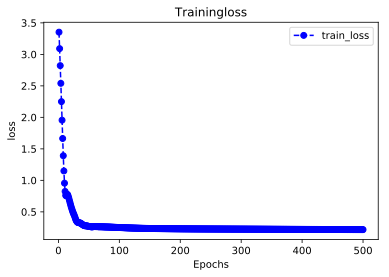

In [40]:
plot_metric(history, "loss")

### 五，使用模型
此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [41]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

confirmed_num  cured_num  dead_num
41          143.0     1681.0      30.0
42           99.0     1678.0      28.0
43           44.0     1661.0      27.0
44           40.0     1535.0      22.0
45           19.0     1297.0      17.0

In [43]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:], axis=0)))
    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict), tf.float32).numpy(),
                            columns=dfresult.columns)
    dfresult = dfresult.append(dfpredict, ignore_index=True)

In [44]:
dfresult.query("confirmed_num==0").head()

# 第50天开始新增确诊降为0，第45天对应3月10日，也就是5天后，即预计3月15日新增确诊降为0
# 注：该预测偏乐观

confirmed_num  cured_num  dead_num
50            0.0      838.0       3.0
51            0.0      766.0       2.0
52            0.0      703.0       1.0
53            0.0      647.0       0.0
54            0.0      597.0       0.0

In [45]:
dfresult.query("cured_num==0").head()

# 第112天开始新增治愈降为0，第45天对应3月10日，也就是大概3个月左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

confirmed_num  cured_num  dead_num
112            0.0        0.0       0.0
113            0.0        0.0       0.0
114            0.0        0.0       0.0
115            0.0        0.0       0.0
116            0.0        0.0       0.0

In [46]:
dfresult.query("dead_num==0").head()

confirmed_num  cured_num  dead_num
53            0.0      647.0       0.0
54            0.0      597.0       0.0
55            0.0      552.0       0.0
56            0.0      511.0       0.0
57            0.0      474.0       0.0

### 六，保存模型

推荐使用TensorFlow原生方式保存模型。

In [47]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.


In [48]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel', compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer, loss=MSPE(name="MSPE"))
model_loaded.predict(ds_train)

array([[1.28645032e+03, 9.31316528e+01, 2.33789563e+00],
       [1.58676514e+03, 7.30236816e+01, 4.75372124e+00],
       [1.73140649e+03, 1.55572189e+02, 4.44200182e+00],
       [1.98146448e+03, 1.66155334e+02, 4.98751068e+00],
       [2.38167993e+03, 2.75161682e+02, 5.06544065e+00],
       [2.26400562e+03, 2.76220001e+02, 5.68887949e+00],
       [1.92630469e+03, 4.09567596e+02, 5.68887949e+00],
       [2.07462329e+03, 5.39740234e+02, 6.70196724e+00],
       [1.62537708e+03, 6.33930237e+02, 6.93575716e+00],
       [1.82211389e+03, 6.68854553e+02, 7.55919600e+00],
       [1.51199292e+03, 7.56694641e+02, 8.41642380e+00],
       [1.23496790e+03, 7.87385742e+02, 7.55919600e+00],
       [9.28585449e+03, 1.23928589e+03, 1.97941837e+01],
       [2.48035474e+03, 8.59351135e+02, 1.01308811e+00],
       [1.50560962e+03, 1.50670081e+03, 6.51277084e+01],
       [1.06602136e+03, 1.42910962e+03, 8.72844543e+01],
       [9.02332520e+02, 1.51787366e+03, 9.40265961e+01],
       [6.56513855e+02, 1.82607